# Import packages

In [1]:
import torch
import torch.nn as nn
import torchdiffeq
from torchdiffeq import odeint
from xitorch.interpolate import Interp1D
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import scipy.optimize as opt
import pickle
import numpy as np
import time

torch.set_default_dtype(torch.float)

# Define classes for parameter-container and sequence generator

In [2]:
"""
Class MassFricParams, manages data of a mass block sliding on rate-and-state friction surface, contains 
    Data:
        k : Spring stiffness
        m : Mass of the block
        V : Leading head speed of the spring
        g : Gravity
        RSParams : rate and state parameters, torch.tensor([a, b, DRS, f*])
        y0 : torch.tensor([initial x_1, initial v_1, initial state variable])
"""
class MassFricParams: 
    # Constructor
    def __init__(self, kmVg, RSParams, y0):
        self.k = kmVg[0]
        self.m = kmVg[1]
        self.V = kmVg[2]
        self.g = kmVg[3]
        self.RSParams = RSParams
        self.y0 = y0
    
    # Output the information of this class
    def print_info(self):
        print("-" * 20, " Mass and spring parameters ", "-"*20)
        print('k:        ', self.k)
        print('m:        ', self.m)
        print('V:        ', self.V)
        print('g:        ', self.g)
        print('\n')
        
        print("-" * 20, " Rate-and-state parameters ", "-"*20)
        print('fr:       ', self.RSParams[3])
        print('a:        ', self.RSParams[0])
        print('b:        ', self.RSParams[1])
        print('DRS:      ', self.RSParams[2])
        print('y0:       ', self.y0)
        

In [3]:
"""
Class TimeSequenceGen, container for a Generated time sequence containing 
    Data:
        MFParams: Mass and friction parameters for the system
        T: Length of calculation
        
    Method:
        __init__ : Constructor
        calculateYAtT: Generate the sequence of [x_1, v_1, theta]
        
"""
class TimeSequenceGen:
    # Constructor
    def __init__(self, T, NofTPts, MFParams, rtol = 1.e-6, atol = 1.e-8, regularizedFlag = True):
        # Load the parameters
        self.T = T
        self.t = torch.linspace(0., T, NofTPts)
        self.MFParams = MFParams
        self.rtol = rtol
        self.atol = atol
        self.regularizedFlag = regularizedFlag
        
        # Generate the sequence
        st = time.time()
        self.default_y = self.calculateYAtT(self.t)
        self.time_cost = time.time() - st
        # print("Time cost to generate the sequence: ", self.time_cost)
        
    # Function DyDt, DyDt = f(t, y)
    def DyDt(self, t, y):
        
        # Need to use regularized rate-and-state
        a = self.MFParams.RSParams[0]
        b = self.MFParams.RSParams[1]
        DRS = self.MFParams.RSParams[2]
        fStar = self.MFParams.RSParams[3]
        
        # Regularized rate-and-state friction
#         tau = self.N * a * torch.asinh(
#                    self.Ds / 2. / Vr * torch.exp((fr + b * torch.log(Vr * self.theta / DRS)) / a)
#                    )
        
        if self.regularizedFlag:
            DyDt = torch.tensor([y[1], 
                                 self.MFParams.k / self.MFParams.m * (self.MFParams.V * t - y[0]) - \
                                 self.MFParams.g * (a * torch.asinh(
                                     y[1] / 2.e-6 * torch.exp((fStar + b * torch.log(1.e-6 * y[2] / DRS)) / a)
                                 )), 
                                 1 - y[2] * 1.e-6 / DRS])
        else:
            DyDt = torch.tensor([y[1], 
                                 self.MFParams.k / self.MFParams.m * (self.MFParams.V * t - y[0]) - \
                                 self.MFParams.g * (fStar + \
                                                    a * torch.log(y[1] / 1.e-6) + \
                                                    b * torch.log(1.e-6 * y[2] / DRS)), 
                                 1 - y[2] * 1.e-6 / DRS])             
        # DEBUG LINES
#         print("-" * 30)
#         print('t = ', t)
#         print('y = ', y)
#         print('DyDt = ', DyDt)
        
        return DyDt
    
    
    # Generate the sequence of y(t) = [x_1(t), v_1(t), theta(t)]
    def calculateYAtT(self, t):
        y = odeint(self.DyDt, self.MFParams.y0, t, 
                   rtol = self.rtol, atol = self.atol, method = 'dopri5')
        return torch.transpose(y, 0, 1)
    
    # Visualize the sequence of y
    def plotY(self, t, y):
        # Plot Sequence of V(t) and N(t) given sample-index
        f, axs = plt.subplots(2, 2, figsize = (15, 15))

        # Plot x_1(t)
        axs[0][0].plot(1e6 * t, y[0, :], linewidth=2.0)
        axs[0][0].set_xlabel('Time [$\mu$ s]', fontsize=20)
        axs[0][0].set_ylabel('Slip $x_1(t)\  \mathrm{[m]}$', fontsize=20)
        # axs[0][0].set_ylim([1e-15, 1e2])
        axs[0][0].grid()

        # Plot v_1(t)
        axs[0][1].semilogy(1e6 * t, y[1, :], linewidth=2.0)
        axs[0][1].set_xlabel('Time [$\mu$ s]', fontsize=20)
        axs[0][1].set_ylabel('Slip rate $v_1(t)\ \mathrm{[m/s]}$', fontsize=20)
        # axs[0][1].set_ylim([0, 15])
        axs[0][1].grid()

        # Plot theta(t)
        axs[1][0].semilogy(1e6 * t, y[2, :], linewidth=3.0)
        axs[1][0].semilogy(1e6 * t, self.MFParams.RSParams[2] / y[1, :], linewidth=2.0)
        axs[1][0].set_xlabel('Time [$\mu$ s]', fontsize=20)
        axs[1][0].set_ylabel('State Variable $\\theta(t)\ \mathrm{[s]}$', fontsize=20)
        axs[1][0].legend(['True', 'Steady state'], loc='best', fontsize=20)
        axs[1][0].grid()

#         # Plot \tau(t)
#         axs[1][1].plot(1e6 * t, tauAll[sample_idx, :], linewidth=2.0)
#         axs[1][1].set_xlabel('Time [$\mu$ s]', fontsize=20)
#         axs[1][1].set_ylabel('Shear traction $\\tau(t)\ \mathrm{[MPa]}$', fontsize=20)
#         axs[1][1].grid()

#         f.suptitle("The " + str(sample_idx) + "th sequence", fontsize = 20)


# Adjoint derivatives

In [4]:
## O = \int_0^T (y[1](t) - v(t)) ^ 2 dt 
# To compute dO / d \beta, one needs to implement six functions
# In all tensors, the last dimension is time

# \partial o(y, yDot, t; \beta) / \partial y
def DoDy(y, v, t, MFParams):
    DoDy = torch.zeros(y.shape)
    DoDy[1, :] = 2. * (y[1, :] - v)
    return DoDy

# \partial o / \partial yDot
def DoDyDot(y, v, t, MFParams):
    return torch.zeros(y.shape)

# d/dt (\partial o / \partial yDot)
def DDoDyDotDt(y, v, t, MFParams):
    return torch.zeros(y.shape)

# \partial o / \partial \beta
def DoDBeta(y, v, t, MFParams):
    return torch.zeros([MFParams.RSParams.shape[0], y.shape[1]])

# \partial C / \partial y, unregularized
def DCDy(y, v, t, MFParams):
    DCDy = torch.zeros([y.shape[0], y.shape[0], y.shape[1]])
    DCDy[0, 1, :] = -1.
    DCDy[1, 0, :] = MFParams.k / MFParams.m
    DCDy[1, 1, :] = MFParams.g * MFParams.RSParams[0] / y[1, :]
    DCDy[1, 2, :] = MFParams.g * MFParams.RSParams[1] / y[2, :]
    DCDy[2, 1, :] = y[2, :] / MFParams.RSParams[2]
    DCDy[2, 2, :] = y[1, :] / MFParams.RSParams[2]
    return DCDy

# \partial C / \partial yDot, unregularized
def DCDyDot(y, v, t, MFParams):
    DCDyDot = torch.zeros([y.shape[0], y.shape[0], y.shape[1]])
    DCDyDot[0, 0, :] = 1.
    DCDyDot[1, 1, :] = 1.
    DCDyDot[2, 2, :] = 1.
    return DCDyDot

# d/dt (\partial C / \partial yDot)
def DDCDyDotDt(y, v, t, MFParams):
    DDCDyDotDt = torch.zeros([y.shape[0], y.shape[0], y.shape[1]])
    return DDCDyDotDt

# \partial C / \partial \beta
def DCDBeta(y, v, t, MFParams):
    DCDBeta = torch.zeros([y.shape[0], MFParams.RSParams.shape[0], y.shape[1]])
    DCDBeta[1, 0, :] = MFParams.g * torch.log(y[1, :] / 1.e-6)
    DCDBeta[1, 1, :] = MFParams.g * torch.log(1.e-6 * y[2, :] / MFParams.RSParams[2])
    DCDBeta[1, 2, :] = -MFParams.g * MFParams.RSParams[1] / MFParams.RSParams[2]
    DCDBeta[1, 3, :] = MFParams.g
    DCDBeta[2, 2, :] = -y[1, :] * y[2, :] / MFParams.RSParams[2] / MFParams.RSParams[2]
    return DCDBeta

# ------------------------ Calculate the derivative: Do / D\beta -------------------------
# Observation
def O(y, v, t, MFParams):
    # Least square error
    O = torch.trapezoid(
        torch.square(y[1, :] - v), 
        t
    )
    
    # print("Relative L2 error: ", torch.sqrt(O) / torch.linalg.norm(v))
    return O

    

In [5]:
# Class Adjoint derivatives
class AdjDerivs:
    # Constructor
    def __init__(self, y, v, t, MFParams, rtol = 1.e-6, atol = 1.e-8):
        self.y = y
        self.v = v
        self.t = t
        
        # Define tau = T - t
        self.T = self.t[-1]
        self.tau = self.T - self.t
        
        # self.tau = torch.flip(self.T - self.t, [0])
        
        self.MFParams = MFParams
        self.rtol = rtol
        self.atol = atol
        
        ## Calculate the partial derivatives ##
        self.dCdy = DCDy(y, v, t, MFParams)
        self.dody = DoDy(y, v, t, MFParams)
        self.dCdyDot = DCDyDot(y, v, t, MFParams)
        self.ddCdyDotdt = DDCDyDotDt(y, v, t, MFParams)
        self.dodyDot = DoDyDot(y, v, t, MFParams)
        self.ddodyDotdt = DDoDyDotDt(y, v, t, MFParams)
        self.dCdBeta = DCDBeta(y, v, t, MFParams)
        self.dodBeta = DoDBeta(y, v, t, MFParams)
        self.dodyDot = DoDyDot(y, v, t, MFParams)
        self.dCdyDot = DCDyDot(y, v, t, MFParams)
        
        # Calculate A_z and u_z
        self.Az = self.A_z()
        self.uz = self.u_z()
        
        # Calculate A_l and u_l
        self.Al = self.A_l()
        self.ul = self.u_l()
        
        # Calculate dOdBeta
        st = time.time()
        self.dOdBeta = self.DODBeta()
        self.time_cost = time.time() - st
        print("Time cost in computing gradients: ", self.time_cost)
    
    ## d\lambda / dtau = f_l(l, tau) = -(l \cdot A_l(tau) + u_l(tau)) ##
    # calculate A_l at tau
    def A_l(self):
        dCdyDot = torch.transpose(self.dCdyDot, 2, 0)
        dCdy = torch.transpose(self.dCdy, 2, 0)
        ddCdyDotdt = torch.transpose(self.ddCdyDotdt, 2, 0)
        
        # Calculate A_l at tSteps
        A_l_discrete = torch.linalg.solve(dCdyDot, dCdy - ddCdyDotdt)
        A_l_discrete = torch.transpose(A_l_discrete, 0, 2)
        
        # DEBUG LINES
        self.A_l_discrete = A_l_discrete
        
        # Compute the interpolation for slip rate Ds
        t_temp = torch.concat([torch.tensor([self.t[0] - 1.]), self.t, torch.tensor([self.t[-1] + 1.])], 0)
        A_l_discrete_temp = torch.concat([A_l_discrete[:, :, [0]], A_l_discrete, A_l_discrete[:, :, [-1]]], -1)
        
        # Return the function
        # A_l = interp1d(self.T - t_temp, A_l_discrete_temp, kind="cubic")
        A_l = interp1d(self.T - t_temp, A_l_discrete_temp)
        return A_l
    
    # Calculate u_l at tau
    def u_l(self):
        dCdyDot = torch.transpose(self.dCdyDot, 2, 0)
        dody = torch.transpose(self.dody, 1, 0)
        ddodyDotdt = torch.transpose(self.ddodyDotdt, 1, 0)
        
        # Calculate u_l at tSteps
        u_l_discrete = torch.linalg.solve(dCdyDot, dody - ddodyDotdt)
        u_l_discrete = torch.movedim(u_l_discrete, 0, 1)
        
        # DEBUG LINES
        self.u_l_discrete = u_l_discrete
    
        # Compute the interpolation for slip rate Ds
        t_temp = torch.concat([torch.tensor([self.t[0] - 1.]), self.t, torch.tensor([self.t[-1] + 1.])], 0)
        u_l_discrete_temp = torch.concat([u_l_discrete[:, [0]], u_l_discrete, u_l_discrete[:, [-1]]], -1)
        
        # Return the function
        # u_l = interp1d(self.T - t_temp, u_l_discrete_temp, kind="cubic")
        u_l = interp1d(self.T - t_temp, u_l_discrete_temp)
        return u_l
    
    # Calculate f_l(self, tau, l)
    def f_l(self, tau, l):
        tau = torch.clip(tau, self.t[0], self.t[-1])
        res = -torch.matmul(l, torch.tensor(self.Al(tau), dtype=torch.float)) - \
              torch.tensor(self.ul(tau), dtype=torch.float)
        return res
    
    ## dz / dt = f_z(z, t) = A_z(t) \cdot z + u_z(t) ##
    # Calculate A_z at t
    def A_z(self):
        dCdyDot = torch.movedim(self.dCdyDot, 2, 0)
        dCdy = torch.movedim(self.dCdy, 2, 0)
        
        # Calculate A_z at tSteps
        A_z_discrete = -torch.linalg.solve(dCdyDot, dCdy)
        A_z_discrete = torch.movedim(A_z_discrete, 0, 2)
        
        # DEBUG LINES
        self.A_z_discrete = A_z_discrete
        
        # Compute the interpolation for slip rate Ds
        t_temp = torch.concat([torch.tensor([self.t[0] - 1.0]), self.t, torch.tensor([self.t[-1] + 1.0])], 0)
        A_z_discrete_temp = torch.concat([A_z_discrete[:, :, [0]], A_z_discrete, A_z_discrete[:, :, [-1]]], -1)
        
        # Return the function
        A_z = interp1d(t_temp, A_z_discrete_temp, kind="cubic")
        return A_z
    
    # Calculate u_z at t
    def u_z(self):
        dCdyDot = torch.movedim(self.dCdyDot, 2, 0)
        dCdBeta = torch.movedim(self.dCdBeta, 2, 0)
        
        # Calculate A_z at tSteps
        u_z_discrete = -torch.linalg.solve(dCdyDot, dCdBeta)
        u_z_discrete = torch.movedim(u_z_discrete, 0, 2)
        
        # DEBUG LINES
        self.u_z_discrete = u_z_discrete
    
        # Compute the interpolation for slip rate Ds
        t_temp = torch.concat([torch.tensor([self.t[0] - 1.0]), self.t, torch.tensor([self.t[-1] + 1.0])], 0)
        u_z_discrete_temp = torch.concat([u_z_discrete[:, :, [0]], u_z_discrete, u_z_discrete[:, :, [-1]]], -1)
        
        # Return the function
        u_z = interp1d(t_temp, u_z_discrete_temp, kind="cubic")
        return u_z
    
    # Calculate f_z
    def f_z(self, t, z):
        
        res = torch.matmul(torch.tensor(self.Az(t), dtype=torch.float), z) + \
              torch.tensor(self.uz(t), dtype=torch.float)
        
        
#         # DEBUG LINES
#         print("-" * 40)
#         print('t = ', t)
#         print('z = ', z)
#         print('f_z: ', res)
        
        return res
    
    # d observation / d \beta
    def DODBeta(self):
        ## First solve for lambda(t) ##
        A = self.dCdy - self.ddCdyDotdt
        B = -self.dody + self.ddodyDotdt

        # Switch dimensions by torch.transpose
        A = torch.transpose(A, 0, 2)
        B = torch.transpose(B, 0, 1)

        # Solve for lambda [Tsteps, ]
        # L = torch.linalg.solve(A, B)
        L0 = torch.zeros(self.y.shape[0])
        
        # Solve for L(t)
        L = odeint(self.f_l, L0, torch.flip(self.tau, [0]), 
                   rtol = self.rtol, atol = self.atol, method = 'dopri5')
        
        L = L.reshape([L.shape[0], 1, L.shape[1]])
        L = torch.flip(L, [0])
        LDCDBeta = torch.movedim(self.dCdBeta, 2, 0)
        LDCDBeta = torch.matmul(L, LDCDBeta)
        LDCDBeta = LDCDBeta.reshape([LDCDBeta.shape[0], LDCDBeta.shape[2]])

#         # DEBUG LINES
#         print('L shape: ', L.shape)
#         print('LDCDBeta shape: ', LDCDBeta.shape)
#         print('L[-1, :, :]: ', L[-1, :, :])
        
        integrand = self.dodBeta + torch.transpose(LDCDBeta, 0, 1)
        DODBeta = torch.trapezoid(
            integrand, 
            self.t
        )
        
        
        
#         ## Then calculate z(T) ##
#         z0 = torch.zeros([self.y.shape[0], self.MFParams.RSParams.shape[0]])
#         zT = odeint(self.f_z, z0, self.t, 
#                     rtol = 1.e-10, atol = 1.e-12, method = 'dopri5')
#         zT_last = zT[-1, :, :]
        
#         # DEBUG LINES 
#         print("zT_last: ", zT_last)
#         print("LT: ", L[-1, :, :])
        
        # DEBUG LINES 
        # print('DODBeta: ', DODBeta)
        
#         DODBeta += ((self.dodyDot[:, -1] + L[-1, :, :] @ self.dCdyDot[:, :, -1]) @ zT_last).reshape([-1])
#         print('DODBeta after boundary term: ', DODBeta)
        
#         ## USE THE ALTERNATIVE WAY
#         DODBeta_alter = torch.trapezoid(
#             2 * (self.y[1, :] - self.v) * torch.transpose(zT[:, 1, :], 0, 1), 
#             self.t
#         )
#         print('DODBeta alternative ', DODBeta_alter)
        
        return DODBeta
        

# Updating using gradient descent

In [46]:
## Fixed parameters
# Parameters for the spring-slider
# k = 50.
# m = 1.
# V = 1.
# g = 9.8
y0 = torch.tensor([0., 1.0, 1.0])
alpha = torch.tensor([54.2049,  1.7979,  9.8089,  9.9849])
k = alpha[0]
m = alpha[1]
V = alpha[2]
g = alpha[3]
y0[1] = alpha[2]

# Sequence specific parameters
T = 5.
NofTPts = 1000

# Tolerance parameters
this_rtol = 1.e-8
this_atol = 1.e-10

# Function observation function
def objGradFunc(beta, targ_y, scaling, objOnly = False):
    # Generate target v
    this_RSParams = beta * scaling
    this_SpringSlider = MassFricParams([k, m, V, g], this_RSParams, y0)
    
    this_seq = TimeSequenceGen(T, NofTPts, this_SpringSlider, 
                               rtol=this_rtol, atol=this_atol, regularizedFlag=False)
    
    # Compute the value of objective function
    obj = O(this_seq.default_y, targ_y, this_seq.t, this_SpringSlider)
    
#     # DEBUG LINES
#     print("-"*30)
#     print("This RS params: ", this_RSParams)
#     print("Objective value: ", obj)
#     print("-"*30)
    
    # Compute dOdBeta
    if objOnly:
        grad = 0.
    else:
        myAdj = AdjDerivs(this_seq.default_y, targ_y, this_seq.t, this_SpringSlider, 
                          rtol = this_rtol, atol = this_atol)
        grad = myAdj.dOdBeta / scaling
        
    return obj, grad


# Give the initial position and gradient updating function
class GradDescent:
    # Constructor, initial value position
    def __init__(self, beta0, beta_low, beta_high, targ_y, t, objGrad_func, max_steps, scaling, 
                 stepping = 'BB', obs_rtol = 1e-5, grad_atol = 1.e-10, lsrh_steps = 10):
        # Initial parameters, and their lower and upper bound
        self.beta0 = beta0 / scaling
        self.beta_low = beta_low / scaling
        self.beta_high = beta_high / scaling
        
        # Scale the gradients to get precisions match
        self.scaling = scaling
        
        # Target sequence
        self.targ_y = targ_y
        
        # Time at which targ_y was observed
        self.t = t
        
        # Objective and gradient function
        self.objGrad_func = objGrad_func
        
        # Maximum number of steps allowed
        self.max_steps = max_steps
        
        # Stepping scheme, either BB or lsrh
        self.stepping = stepping
        
        # Tolerance of observation relative error
        self.obs_tol = obs_rtol
        
        # Tolerance of gradient absolute error
        self.grad_atol = grad_atol
        
        # Sequence of parameters
        self.betas = [self.beta0]
        
        # Maximum line search steps
        self.lsrh_steps = lsrh_steps
        
        # Get Initial observations
        self.objs = []
    
    # First descent, cannot use Barzilai–Borwein stepping, using linesearch
    def firstDescent(self):
        # Compute obj and grad
        obj, grad = self.objGrad_func(self.betas[-1], self.targ_y, self.scaling)
        self.objs = [obj]
        self.grads = [grad]
        
        # Norm of gradients
        self.grad_norms = torch.linalg.norm(grad).reshape([-1])
        
        # Perform linesearch
        return self.lineSearch()
    
    # Run one descent using either Barzilai–Borwein stepping or linesearch
    def oneDescent(self):
        # Make sure there are more than 1 steps beforehand
        assert(len(self.objs) >= 2)
        
        # Compute BB stepsize
        BBStepSize = abs(torch.dot(self.betas[-1] - self.betas[-2], self.grads[-1] - self.grads[-2])) / \
                       torch.sum(torch.square(self.grads[-1] - self.grads[-2]))
        
        # Calculate the step size
        if self.stepping == 'BB':
            stepSize = BBStepSize
            beta_trial = self.project(self.betas[-1] - stepSize * self.grads[-1])

            # Append the betas and objs
            obj_trial, grad_trial = self.objGrad_func(beta_trial, self.targ_y, self.scaling, objOnly = False)
            self.betas.append(beta_trial)
            self.objs.append(obj_trial)
            self.grads.append(grad_trial)
            self.grad_norms = torch.concat([self.grad_norms, torch.linalg.norm(grad_trial).reshape([-1])])
            
            # Return if obj_trial is smaller than obj
            return obj_trial < self.objs[-2]
        
        # Line search mechanism
        elif self.stepping == 'lsrh':
            return self.lineSearch(BBStepSize)
        
    
    # Run gradient descent
    def run(self):
        # Run initial descent
        success = self.firstDescent()
        print("=" * 40)
        print("Initial descent succeeds: ", success)
        print("Observation: ", self.objs[-1])
        print("Gradient (scaled): ", self.grads[-1])
        print("Relative error of observation: ", torch.sqrt(self.objs[-1]) / torch.linalg.norm(self.targ_y))
        
        if torch.min(self.grad_norms) < self.grad_atol:
            print("The final predicted parameters: ", self.betas[torch.argmin(self.grad_norms)])
            return
        
        # Run max_iters number of iterations
        for i in range(self.max_steps):
            success = self.oneDescent()
            print("=" * 40)
            print("The {0}th descent succeeds: ".format(i + 1), success)
#             print("Observation: ", self.objs[-1])
            print("Gradient (scaled): ", self.grads[-1])
            print("Relative error of observation: ", torch.sqrt(self.objs[-1]) / torch.linalg.norm(self.targ_y))
            
            # Check if the gradient is small enough
            if torch.min(self.grad_norms) < self.grad_atol:
                break
        
        # Return
        print("The final predicted parameters: ", self.betas[torch.argmin(self.grad_norms)] * scaling)
        return
    
    # Line search functino
    def lineSearch(self, minStepSize = 0.):
        # Find stepsize
        maxStepSize = 0.1 * min(abs(self.betas[-1] / self.grads[-1]))
            
        # Line search
        stepSize = max(maxStepSize, minStepSize)
        
        for i in range(self.lsrh_steps):
            beta_trial = self.project(self.betas[-1] - stepSize * self.grads[-1])
            obj_trial, grad_trial = self.objGrad_func(beta_trial, self.targ_y, self.scaling, objOnly = True)
            print("shit")
            
            # Break if this beta is good
            if (stepSize < minStepSize) or (obj_trial < self.objs[-1]):
                break
            
            # Half the stepSize
            stepSize = stepSize / 2.
        
        # If linesearch exits but minimum step size hasn't been reached, try with minimum step size
        if (minStepSize > 0.) and (stepSize >= minStepSize) and (obj_trial > self.objs[-1]):
            beta_trial = self.project(self.betas[-1] - minStepSize * self.grads[-1])
        
        # Append the betas and objs
        obj_trial, grad_trial = self.objGrad_func(beta_trial, self.targ_y, self.scaling, objOnly = False)
        self.betas.append(beta_trial)
        self.objs.append(obj_trial)
        self.grads.append(grad_trial)
        self.grad_norms = torch.concat([self.grad_norms, torch.linalg.norm(grad_trial).reshape([-1])])
        
        # Return if obj_trial is smaller than obj
        return obj_trial < self.objs[-2]
        
    
    # Project the new point into the constraint set
    def project(self, pt):
        fun = lambda u: np.linalg.norm(u - np.array(pt))
        prjted = opt.minimize(fun, x0 = np.array((self.beta_low + self.beta_high) / 2.), 
                              bounds = [(self.beta_low[i], self.beta_high[i]) 
                                        for i in range(len(self.beta_low))]
                             ).x
        return torch.tensor(prjted, dtype=torch.float)

# Optimize by $\alpha=[k, m, V, g]$

In [44]:
# Sequence specific parameters
T = 5.
NofTPts = 1000

# Tolerance parameters
this_rtol = 1.e-8
this_atol = 1.e-10

# Obtain observation at (alpha, beta_this, beta_targ, y0)
def O_GAN(alpha, beta_this, beta_targ, y0, regFlag):
    # Changing the y0 to match V with v 
    alp = torch.tensor(alpha)
    y0[1] = alp[2]
    
    # DEBUG LINES
    print('alpha: ', alpha)
#     print('beta_this: ', beta_this)
#     print('beta_targ: ', beta_targ)
#     print('y0: ', y0)
    
    # Get target sequence
    targ_SpringSlider = MassFricParams(alp, beta_targ, y0)
    
    # Run the sequence
    targ_seq = TimeSequenceGen(T, 
                               NofTPts, 
                               targ_SpringSlider, 
                               rtol=this_rtol, 
                               atol=this_atol, 
                               regularizedFlag=regFlag)
#     # DEBUG LINE: Print targ seq finished
#     print("Target sequence finished.")
    v = targ_seq.default_y[1, :]
    
    # Get this sequence
    this_SpringSlider = MassFricParams(alp, beta_this, y0)
    this_seq = TimeSequenceGen(T, 
                               NofTPts, 
                               this_SpringSlider, 
                               rtol=this_rtol, 
                               atol=this_atol, 
                               regularizedFlag=regFlag)
    
#     # DEBUG LINE
#     print("This sequence finished.")
    res = O(this_seq.default_y, v, this_seq.t, this_SpringSlider)
    
    # DEBUG LINE
    print('Objective value: ', res, '\n')
    
    return res

# Try to find maximum of O_GAN in terms of alpha
def optAlpha(Obs_func, kwargs):
    # Unzip the arguments
    beta_this = kwargs['beta_this']
    alpha0 = kwargs['alpha0']
    beta_targ = kwargs['beta_targ']
    y0 = kwargs['y0']
    
    # Other parameters for simulated annealing function
    alp_low = kwargs['alp_low']
    alp_hi = kwargs['alp_hi']
    max_iters = kwargs['max_iters']
    regFlag = kwargs['regularizedFlag']
    maxFuncCalls = kwargs['maxFuncCalls']
    noLocalSearch = kwargs['noLocalSearch']
    
    # Define the function
    func = lambda x: -Obs_func(x, beta_this, beta_targ, y0, regFlag)
    
    # Use dual-simulated-annealing grad-free method to optimize for alpha
    new_alpha = opt.dual_annealing(func, 
                                   [(alp_low[i], alp_hi[i]) for i in range(len(alp_low))], 
                                   maxiter = max_iters, 
                                   x0 = alpha0, 
                                   maxfun = maxFuncCalls, 
                                   no_local_search = noLocalSearch
                                  ).x
    
    return torch.tensor(new_alpha, dtype = torch.float)

In [40]:
## Fixed initial parameters
# Parameters for the spring-slider
k = 80.
m = 1.
V = 1.
g = 9.8

alpha0 = torch.tensor([k, m, V, g])
y0 = torch.tensor([0., 1.0, 1.0])

beta0 = torch.tensor([0.004, 0.008, 2.e-3, 0.5])
beta_targ = torch.tensor([0.011, 0.016, 1.e-3, 0.58])

# Other arguments for optAlpha function
alp_low = torch.tensor([50., 0.5, 1., 9.])
alp_hi = torch.tensor([100., 2., 10., 10.])
max_iters = 10
maxFuncCalls = 100
regularizedFlag = False
noLocalSearch = True

# Store the keywords
kwgs = {
    'beta_this' : beta0, 
    'beta_targ' : beta_targ, 
    'y0' : y0, 
    'alp_low' : alp_low, 
    'alp_hi' : alp_hi, 
    'max_iters' : max_iters, 
    'alpha0' : alpha0, 
    'regularizedFlag' : regularizedFlag, 
    'maxFuncCalls' : maxFuncCalls, 
    'noLocalSearch' : noLocalSearch
}

# Run the optimization using simulated annealing
res = optAlpha(O_GAN, kwgs)

alpha:  [80.   1.   1.   9.8]
Objective value:  tensor(0.0160) 

alpha:  [95.16623747  1.66623747  3.16623747  9.36388285]
Objective value:  tensor(0.0528) 

alpha:  [58.46795124  0.97684789  4.46795124  9.17449327]
Objective value:  tensor(0.0545) 

alpha:  [86.98437093  0.99326758  5.98437093  9.89333436]
Objective value:  tensor(0.0471) 

alpha:  [67.03713481  0.93592501  4.03713481  9.74367684]
Objective value:  tensor(0.0495) 

alpha:  [71.963462    0.97684789  4.46795124  9.17449327]
Objective value:  tensor(0.0450) 

alpha:  [58.46795124  1.43533474  4.46795124  9.17449327]
Objective value:  tensor(0.0799) 

alpha:  [58.46795124  1.43533474  3.36355683  9.17449327]
Objective value:  tensor(0.0725) 

alpha:  [58.46795124  1.43533474  4.46795124  9.5724349 ]
Objective value:  tensor(0.0863) 

alpha:  [70.68690562  0.65428913  1.1282492   9.23273286]
Objective value:  tensor(0.0137) 

alpha:  [94.12208012  1.04833144  5.58094794  9.6854316 ]
Objective value:  tensor(0.0429) 

alpha

In [41]:
res

tensor([54.2049,  1.7979,  9.8089,  9.9849], dtype=torch.float64)

In [43]:
alp_this = torch.tensor([54.2049,  1.7979,  9.8089,  9.9849])
O_GAN(alp_this, beta0, beta_targ, y0, False)

<ipython-input-39-efa8a6446bd9>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alp = torch.tensor(alpha)


alpha:  tensor([54.2049,  1.7979,  9.8089,  9.9849])
Objective value:  tensor(0.1574) 



tensor(0.1574)

# Fixed parameters

In [45]:
# Generate target v
targ_RSParams = torch.tensor([0.011, 0.016, 1.e-3, 0.58])
targ_alpha = torch.tensor([54.2049,  1.7979,  9.8089,  9.9849])
y0[1] = targ_alpha[2]
targ_SpringSlider = MassFricParams(targ_alpha, targ_RSParams, y0)

targ_seq = TimeSequenceGen(T, NofTPts, targ_SpringSlider, rtol=this_rtol, atol=this_atol, regularizedFlag=False)
v = targ_seq.default_y[1, :]

# One gradient descent example

In [47]:
# Initialize a grad example using BB stepping
beta0 = torch.tensor([0.004, 0.008, 2.e-3, 0.5])
beta_low = torch.tensor([0.001, 0.006, 0.5e-3, 0.3])
beta_high = torch.tensor([0.021, 0.026, 5, 0.8])
scaling = torch.tensor([1., 1., 1., 1.])
myGradBB = GradDescent(beta0, beta_low, beta_high, v, targ_seq.t, objGrad_func = objGradFunc, scaling = scaling, 
                       max_steps = 200, obs_rtol = 1e-5, lsrh_steps = 10)

In [ ]:
myGradBB.run()

Time cost in computing gradients:  15.498671054840088
shit
Time cost in computing gradients:  15.262974977493286
Initial descent succeeds:  tensor(True)
Observation:  tensor(0.1403)
Gradient (scaled):  tensor([-3.3695e+01,  1.6491e+01,  1.2674e-03, -2.1816e+00])
Relative error of observation:  tensor(0.0012)
Time cost in computing gradients:  15.150499820709229
The 1th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([-3.7872e+00,  1.8673e+00, -1.0251e-03, -2.4776e-01])
Relative error of observation:  tensor(0.0001)
Time cost in computing gradients:  15.279541969299316
The 2th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([-0.8284,  0.4051, -0.0009, -0.0544])
Relative error of observation:  tensor(3.5571e-05)
Time cost in computing gradients:  15.321748971939087
The 3th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([-0.1623,  0.0755, -0.0010, -0.0108])
Relative error of observation:  tensor(1.9283e-05)


In [20]:
# Initialize a grad example using linesearch stepping
beta0 = torch.tensor([0.004, 0.008, 1.e-3, 0.6])
beta_low = torch.tensor([0.001, 0.006, 0.5e-3, 0.3])
beta_high = torch.tensor([0.021, 0.026, 5, 0.8])
scaling = torch.tensor([1., 1., 1., 1.])
myGradLSRH = GradDescent(beta0, beta_low, beta_high, v, targ_seq.t, objGrad_func = objGradFunc, scaling = scaling, 
                         max_steps = 200, stepping = 'BB', obs_rtol = 1e-5, lsrh_steps = 10)

In [21]:
myGradLSRH.run()

Time cost in computing gradients:  4.857542276382446
shit
Time cost in computing gradients:  4.143276929855347
Initial descent succeeds:  tensor(True)
Observation:  tensor(0.0090)
Gradient (scaled):  tensor([ 0.5832, -2.4804, -0.0396,  0.3594])
Relative error of observation:  tensor(0.0027)
Time cost in computing gradients:  3.6600677967071533
The 1th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([-1.7050,  0.2263, -0.0086, -0.0330])
Relative error of observation:  tensor(0.0024)
Time cost in computing gradients:  3.697246551513672
The 2th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([-0.5308, -0.6681, -0.0205,  0.0954])
Relative error of observation:  tensor(0.0017)
Time cost in computing gradients:  3.6124017238616943
The 3th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([-0.6085, -0.4370, -0.0167,  0.0621])
Relative error of observation:  tensor(0.0015)
Time cost in computing gradients:  3.520984411239624
The 4th descent succeeds:  tensor(True

Time cost in computing gradients:  3.5640101432800293
The 32th descent succeeds:  tensor(False)
Gradient (scaled):  tensor([ 0.0001, -0.0008,  0.0004,  0.0002])
Relative error of observation:  tensor(1.9011e-05)
Time cost in computing gradients:  2.8062307834625244
The 33th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([-4.7223e-05, -6.9557e-04,  3.8181e-04,  1.6676e-04])
Relative error of observation:  tensor(1.8968e-05)
Time cost in computing gradients:  3.631953716278076
The 34th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([ 0.0002, -0.0010,  0.0004,  0.0002])
Relative error of observation:  tensor(1.8965e-05)
Time cost in computing gradients:  2.9725770950317383
The 35th descent succeeds:  tensor(False)
Gradient (scaled):  tensor([-6.7588e-04, -1.6250e-04,  4.0498e-04,  9.1456e-05])
Relative error of observation:  tensor(1.8968e-05)
Time cost in computing gradients:  2.8787894248962402
The 36th descent succeeds:  tensor(False)
Gradient (scaled):  tensor(

Time cost in computing gradients:  3.71431565284729
The 64th descent succeeds:  tensor(False)
Gradient (scaled):  tensor([ 0.0015, -0.0022,  0.0004,  0.0004])
Relative error of observation:  tensor(1.9670e-05)
Time cost in computing gradients:  2.9369819164276123
The 65th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([ 0.0012, -0.0018,  0.0004,  0.0003])
Relative error of observation:  tensor(1.9667e-05)
Time cost in computing gradients:  3.577944278717041
The 66th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([-0.0003, -0.0005,  0.0004,  0.0001])
Relative error of observation:  tensor(1.9588e-05)
Time cost in computing gradients:  2.9867048263549805
The 67th descent succeeds:  tensor(False)
Gradient (scaled):  tensor([ 0.0003, -0.0012,  0.0004,  0.0002])
Relative error of observation:  tensor(1.9724e-05)
Time cost in computing gradients:  2.9756908416748047
The 68th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([ 9.2092e-05, -9.1581e-04,  3.8434e

Time cost in computing gradients:  3.030097723007202
The 97th descent succeeds:  tensor(False)
Gradient (scaled):  tensor([-0.0002, -0.0007,  0.0004,  0.0002])
Relative error of observation:  tensor(2.0589e-05)
Time cost in computing gradients:  3.847736358642578
The 98th descent succeeds:  tensor(False)
Gradient (scaled):  tensor([ 0.0010, -0.0018,  0.0004,  0.0003])
Relative error of observation:  tensor(2.0622e-05)
Time cost in computing gradients:  3.045278310775757
The 99th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([ 3.0577e-05, -9.4078e-04,  4.1098e-04,  2.0915e-04])
Relative error of observation:  tensor(2.0536e-05)
Time cost in computing gradients:  3.874709367752075
The 100th descent succeeds:  tensor(False)
Gradient (scaled):  tensor([-3.6632e-05, -7.8306e-04,  4.0762e-04,  1.8720e-04])
Relative error of observation:  tensor(2.0629e-05)
Time cost in computing gradients:  3.6913962364196777
The 101th descent succeeds:  tensor(False)
Gradient (scaled):  tensor(

Time cost in computing gradients:  3.118083953857422
The 129th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([ 7.7927e-05, -1.1382e-03,  4.8698e-04,  2.4396e-04])
Relative error of observation:  tensor(2.1809e-05)
Time cost in computing gradients:  3.908543586730957
The 130th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([-8.9725e-05, -9.0051e-04,  4.4494e-04,  2.0984e-04])
Relative error of observation:  tensor(2.1796e-05)
Time cost in computing gradients:  3.7901368141174316
The 131th descent succeeds:  tensor(False)
Gradient (scaled):  tensor([ 0.0013, -0.0023,  0.0004,  0.0004])
Relative error of observation:  tensor(2.1997e-05)
Time cost in computing gradients:  3.1126224994659424
The 132th descent succeeds:  tensor(False)
Gradient (scaled):  tensor([-0.0031,  0.0014,  0.0005, -0.0001])
Relative error of observation:  tensor(2.2331e-05)
Time cost in computing gradients:  3.1324756145477295
The 133th descent succeeds:  tensor(True)
Gradient (scaled):  tens

Time cost in computing gradients:  3.3996036052703857
The 161th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([ 0.0004, -0.0013,  0.0005,  0.0003])
Relative error of observation:  tensor(2.3878e-05)
Time cost in computing gradients:  4.037033319473267
The 162th descent succeeds:  tensor(False)
Gradient (scaled):  tensor([ 0.0001, -0.0015,  0.0004,  0.0003])
Relative error of observation:  tensor(2.4030e-05)
Time cost in computing gradients:  3.3526828289031982
The 163th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([-0.0008, -0.0005,  0.0005,  0.0002])
Relative error of observation:  tensor(2.3902e-05)
Time cost in computing gradients:  4.084284067153931
The 164th descent succeeds:  tensor(False)
Gradient (scaled):  tensor([ 0.0013, -0.0021,  0.0005,  0.0004])
Relative error of observation:  tensor(2.3922e-05)
Time cost in computing gradients:  3.4046032428741455
The 165th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([ 0.0011, -0.0021,  0.0005,  

Time cost in computing gradients:  3.5598301887512207
The 194th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([ 0.0013, -0.0025,  0.0005,  0.0005])
Relative error of observation:  tensor(2.5134e-05)
Time cost in computing gradients:  4.271505832672119
The 195th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([ 0.0010, -0.0023,  0.0005,  0.0004])
Relative error of observation:  tensor(2.5121e-05)
Time cost in computing gradients:  4.203165292739868
The 196th descent succeeds:  tensor(False)
Gradient (scaled):  tensor([-0.0008, -0.0008,  0.0005,  0.0002])
Relative error of observation:  tensor(2.5190e-05)
Time cost in computing gradients:  3.564145803451538
The 197th descent succeeds:  tensor(False)
Gradient (scaled):  tensor([ 0.0005, -0.0019,  0.0005,  0.0004])
Relative error of observation:  tensor(2.5202e-05)
Time cost in computing gradients:  3.5517842769622803
The 198th descent succeeds:  tensor(False)
Gradient (scaled):  tensor([ 0.0005, -0.0019,  0.0005,  

## Give an example:

In [254]:
## Fixed parameters
# Parameters for the spring-slider
k = 50.
m = 1.
V = 1.
g = 9.8
y0 = torch.tensor([0., 1.0, 1.0])

# Sequence specific parameters
T = 5.
NofTPts = 1000

# Tolerance parameters
this_rtol = 1.e-6
this_atol = 1.e-8

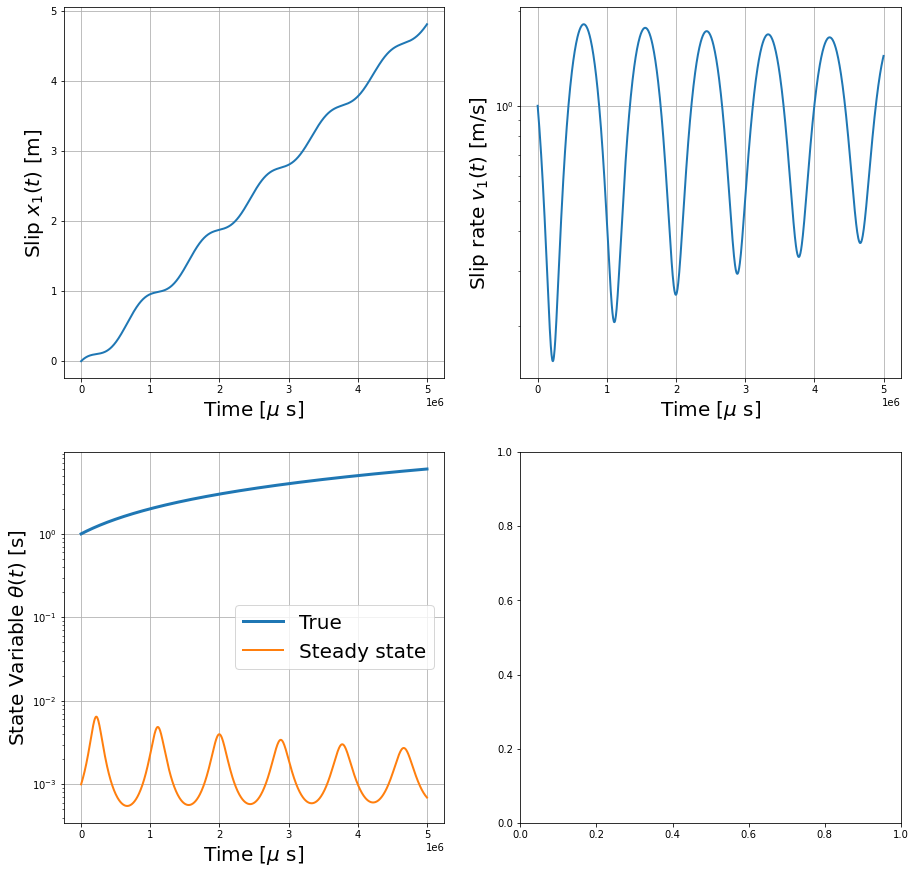

In [255]:
# Generate target v
targ_RSParams = torch.tensor([0.011, 0.016, 1.e-3, 0.58])
targ_SpringSlider = MassFricParams(k, m, V, g, targ_RSParams, y0)

targ_seq = TimeSequenceGen(T, NofTPts, targ_SpringSlider, rtol=this_rtol, atol=this_atol, regularizedFlag=False)
v = targ_seq.default_y[1, :]
targ_seq.plotY(targ_seq.t, targ_seq.default_y)

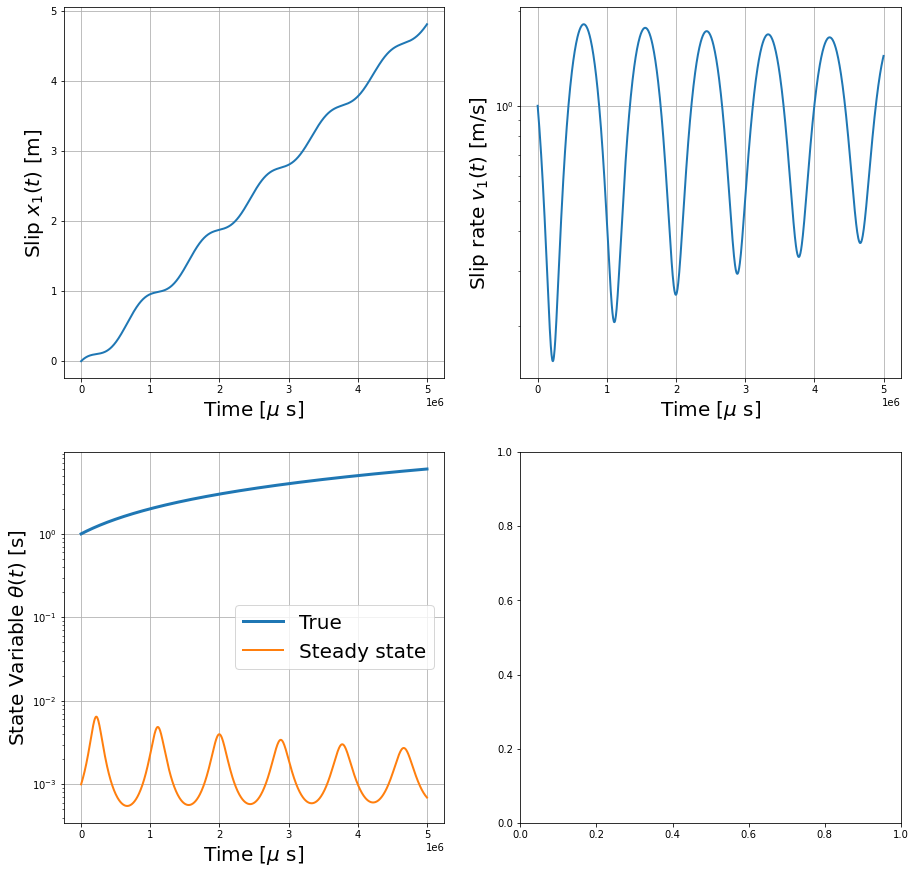

In [257]:
# A new set of RS params
# new_RSParams = torch.tensor([0.004, 0.008, 2., 0.6])
new_RSParams = torch.tensor([0.011, 0.016, 1.e-3, 0.58])
new_SpringSlider = MassFricParams(k, m, V, g, new_RSParams, y0)
new_seq = TimeSequenceGen(T, NofTPts, new_SpringSlider, rtol=this_rtol, atol=this_atol, regularizedFlag=False)
new_seq.plotY(new_seq.t, new_seq.default_y)

In [258]:
# Report observation:
Obs = O(new_seq.default_y, v, new_seq.t, new_SpringSlider)
print('Observation vector: ', Obs)

Observation vector:  tensor(0.)


In [259]:
# Calculate DoDBeta
myADJ = AdjDerivs(new_seq.default_y, v, new_seq.t, new_SpringSlider, rtol = 1.e-6, atol = 1.e-8)


Time cost in computing gradients:  0.15562748908996582


In [261]:
myADJ.dOdBeta

tensor([0., 0., 0., 0.])

In [260]:
myADJ.T

tensor(5.)

In [127]:
# Get the finite-difference gradients
perturbRatio = 0.001
numericalGrad = torch.zeros(new_RSParams.shape)
Rtol = 1.e-10
Atol = 1.e-12

# Loop through all beta's components
for i in range(len(new_RSParams)):
    RSParamsPlus = torch.clone(new_RSParams)
    RSParamsPlus[i] = RSParamsPlus[i] * (1 + perturbRatio)
    RSParamsMinus = torch.clone(new_RSParams)
    RSParamsMinus[i] = RSParamsMinus[i] * (1 - perturbRatio)
    
    print("-" * 40)
    print("RSParams: ", new_RSParams)
    print("RSParamsPlus: ", RSParamsPlus)
    print("RSParamsMinus: ", RSParamsMinus)
    
    # Calculate two observations
    SpringSliderPlus = MassFricParams(k, m, V, g, RSParamsPlus, y0)
    seqPlus = TimeSequenceGen(T, NofTPts, SpringSliderPlus, Rtol, Atol, regularizedFlag=False)
    OPlus = O(seqPlus.default_y, v, seqPlus.t, SpringSliderPlus)
    
    SpringSliderMinus = MassFricParams(k, m, V, g, RSParamsMinus, y0)
    seqMinus = TimeSequenceGen(T, NofTPts, SpringSliderMinus, Rtol, Atol, regularizedFlag=False)
    OMinus = O(seqMinus.default_y, v, seqMinus.t, SpringSliderMinus)
    
    numericalGrad[i] = (OPlus - OMinus) / (RSParamsPlus[i] - RSParamsMinus[i])

print('Numerical gradient: ', numericalGrad)

----------------------------------------
RSParams:  tensor([0.0110, 0.0160, 0.0020, 0.5800])
RSParamsPlus:  tensor([0.0110, 0.0160, 0.0020, 0.5800])
RSParamsMinus:  tensor([0.0110, 0.0160, 0.0020, 0.5800])
Time cost to generate the sequence:  18.004094123840332
Relative L2 error:  tensor(0.0005)
Time cost to generate the sequence:  16.35990333557129
Relative L2 error:  tensor(0.0005)
----------------------------------------
RSParams:  tensor([0.0110, 0.0160, 0.0020, 0.5800])
RSParamsPlus:  tensor([0.0110, 0.0160, 0.0020, 0.5800])
RSParamsMinus:  tensor([0.0110, 0.0160, 0.0020, 0.5800])
Time cost to generate the sequence:  16.547524213790894
Relative L2 error:  tensor(0.0005)
Time cost to generate the sequence:  16.958455085754395
Relative L2 error:  tensor(0.0005)
----------------------------------------
RSParams:  tensor([0.0110, 0.0160, 0.0020, 0.5800])
RSParamsPlus:  tensor([0.0110, 0.0160, 0.0020, 0.5800])
RSParamsMinus:  tensor([0.0110, 0.0160, 0.0020, 0.5800])
Time cost to genera